In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['just as we cannot renew an illusion we have once seen through',
 'prince andrew stood right in front of kutuzov but the expression of the',
 'permission to ride round the position to see the disposition of the',
 'he were saying something which had long since been agreed upon and could',
 'now then go on go on incited the officer bending forward and',
 'antechamber experienced the same feeling of respect and even fear when',
 'sonya again interrupted she gave him an imploring frightened look',
 'shots came',
 '',
 '']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 5 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 5]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 2.4593,  0.7093,  0.9541,  ..., -0.2597, -2.0091, -0.1171],
        [ 0.6571, -0.8933,  0.0521,  ..., -0.6877, -2.3439,  0.1057],
        [-0.4515, -0.5630,  0.0653,  ..., -0.1028,  0.4566,  0.5491],
        ...,
        [-0.2015,  0.3673, -0.5323,  ...,  0.3088, -0.3769,  1.1592],
        [ 0.4471,  0.0181, -0.9749,  ..., -0.3397,  0.9028, -1.4775],
        [-1.0524,  1.3266, -0.1804,  ..., -0.1478,  1.8966, -0.0550]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_30/1837562056.py line 8 
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 15:27:09.058000 132898033727296 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 designs peer august halfway clavichord bezukhova bandoliers spectators successfully diese hadnt says pe applause neighboring exertionsthe noiseless downcast granting gentille restless end fruschtique ranki sways stable greatly unsmiling propos dormir rotten weaknesses earned blister forestalled mironov which sealing fiercely cleanshaven ominously smeared hoarsely antique strut disintegration silkcurtained followers ivanushka artillery offense unfordable pouches powdah squeaked base wet blinking sentry trying naval condescending innocent barefoot tuesday legends pebble camel grandfather are ditch revelation wriggled snubnosed recollections darling grayish doctor shelters calms forwarded strawberries skull fearresembling cleverer tantalizing occur wedge trick nest career branches thumping labors stained summer rasgulyaythe fraternity divided emperorsthat
 conspicuous household grandee mary practice fierce retirement akhrosimova moscovites karagina float unintelligible glamour vivat fors

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([512, 160])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [15]:
len(stoi)

11189

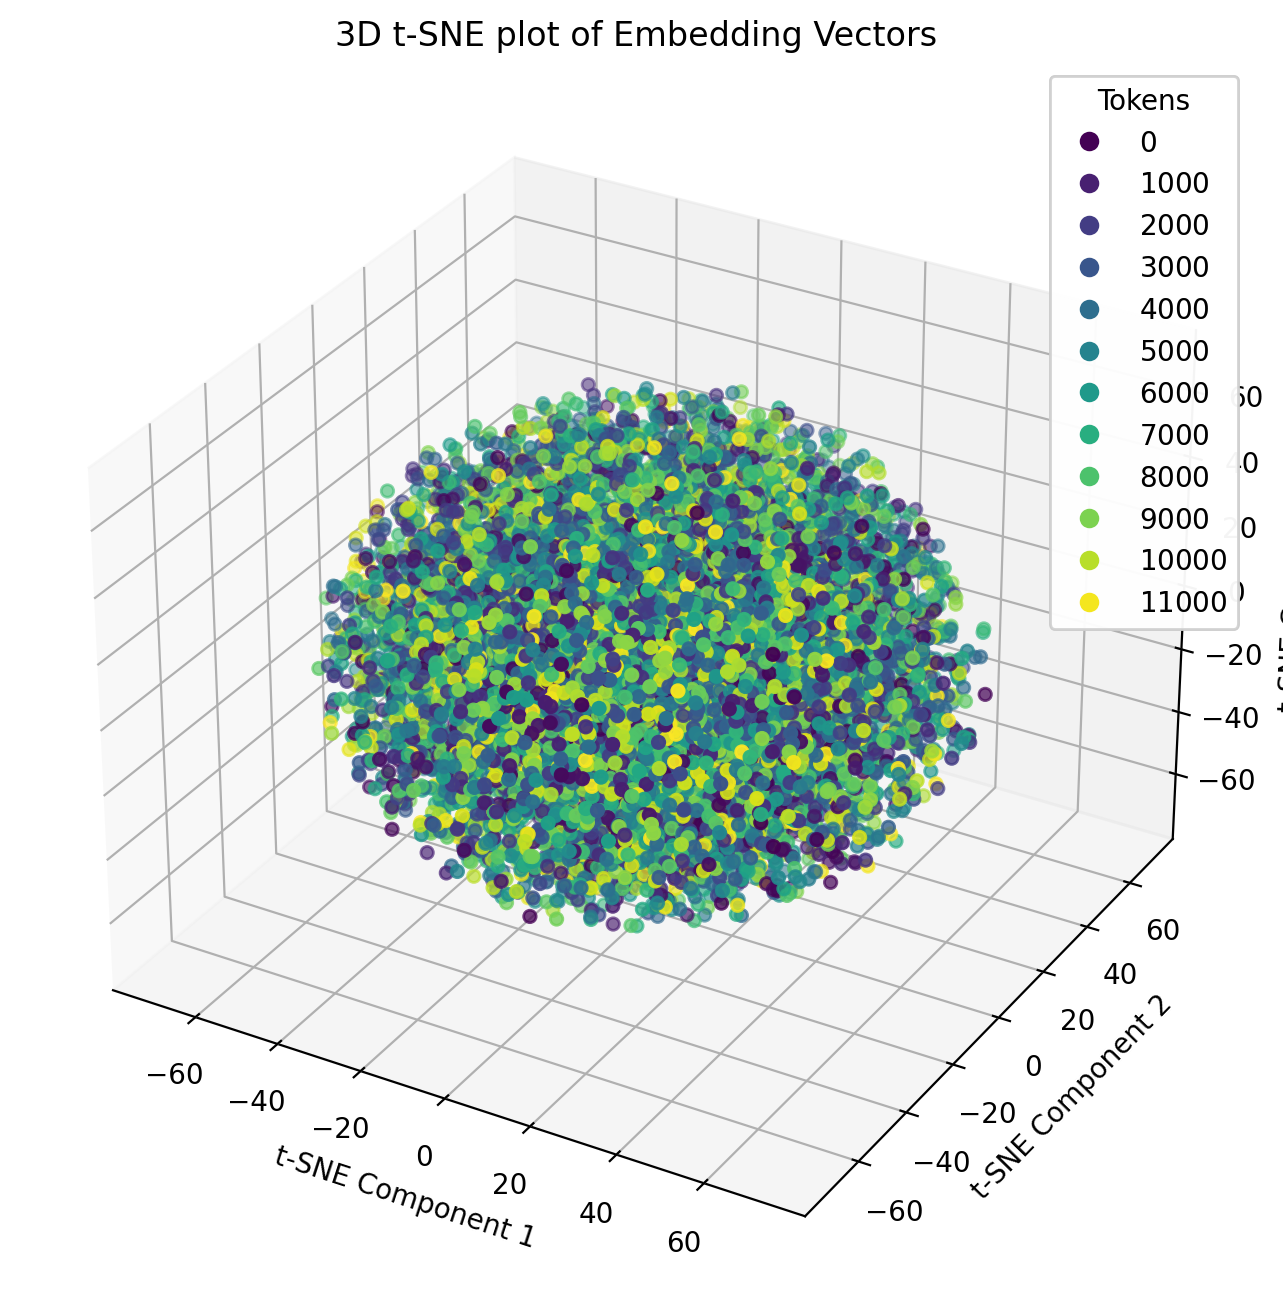

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

tokens = list(stoi.keys())

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [17]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 11.657039642333984
Epoch 10, Loss: 8.594268798828125
Epoch 20, Loss: 7.956143379211426
Epoch 30, Loss: 7.461109161376953
Epoch 40, Loss: 7.009848117828369
Epoch 50, Loss: 6.5863356590271
Epoch 60, Loss: 6.184385776519775
Epoch 70, Loss: 5.799749851226807
Epoch 80, Loss: 5.433938026428223
Epoch 90, Loss: 5.095170021057129
Epoch 100, Loss: 4.7989277839660645
Epoch 110, Loss: 4.55694580078125
Epoch 120, Loss: 4.365057468414307
Epoch 130, Loss: 4.211257457733154
Epoch 140, Loss: 4.084604740142822
Epoch 150, Loss: 3.9771759510040283
Epoch 160, Loss: 3.884049415588379
Epoch 170, Loss: 3.801412582397461
Epoch 180, Loss: 3.7267918586730957
Epoch 190, Loss: 3.658456802368164
Epoch 200, Loss: 3.5950443744659424
Epoch 210, Loss: 3.535460948944092
Epoch 220, Loss: 3.4792048931121826
Epoch 230, Loss: 3.4256138801574707
Epoch 240, Loss: 3.3741049766540527
Epoch 250, Loss: 3.3245608806610107
Epoch 260, Loss: 3.2768797874450684
Epoch 270, Loss: 3.231051445007324
Epoch 280, Loss: 3.18690

In [18]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 from all man who so young
 and zeal with her arms
 theyve drawing room as if just so you that my good the
 when he looked at his feet sonya again without god look as
 yes i was said how i he also a bear descent germany the honor of the
 you wont marry to bring
 
 why is it you
 though stood one not waiting for a word he was
 


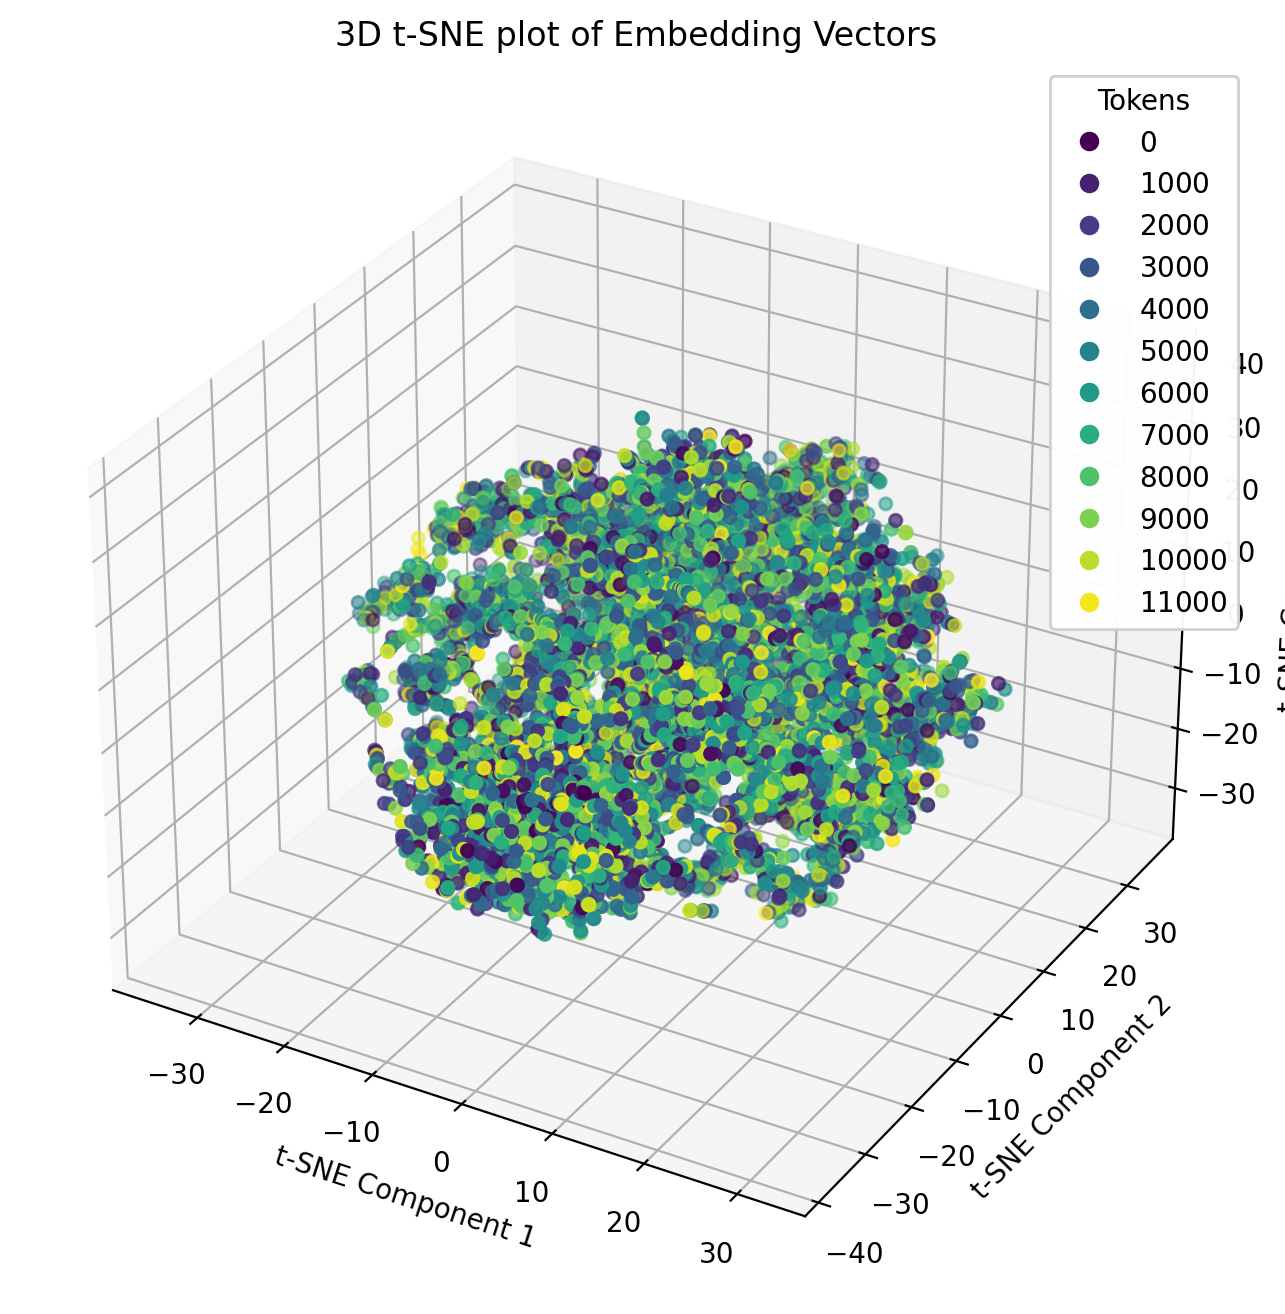

In [19]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [20]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_5_32_512_r.pth")

In [21]:
model = model.to(device)

In [22]:
pd_itos_i = [i for s,i in stoi.items()]
pd_itos_s = [s for s,i in stoi.items()]

pd_itos = pd.DataFrame({"i":pd_itos_i, "s":pd_itos_s})
pd_stoi = pd.DataFrame({"s":pd_itos_s, "i":pd_itos_i})

pd_itos.to_csv('itos.csv')
pd_stoi.to_csv('stoi.csv')